# MS Stock Forecasting

In [ ]:
import pandas as pd 
import numpy as np

from tensorflow import keras 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sns 

import os 
from datetime import datetime

In [470]:
# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [471]:
df_stock = pd.read_csv("../../data/ms_stock_forecasting.csv")
df_stock.head()

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [472]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [473]:
df_stock.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


## Open and Close Prices of time

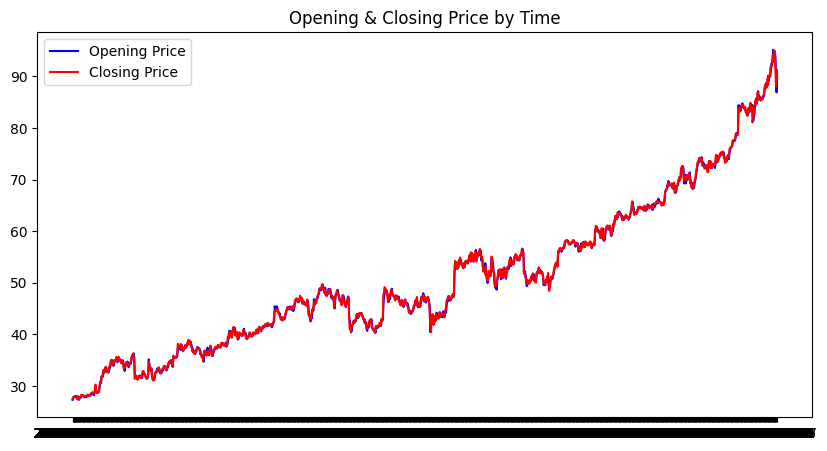

In [474]:
# Initial Data Visualization
plt.figure(figsize=(10,5))
plt.plot(df_stock['date'], df_stock['open'], label="Opening Price",color="blue")
plt.plot(df_stock['date'], df_stock['close'], label="Closing Price",color="red")
plt.title("Opening & Closing Price by Time")
plt.legend()
plt.show()

## Trading Volume

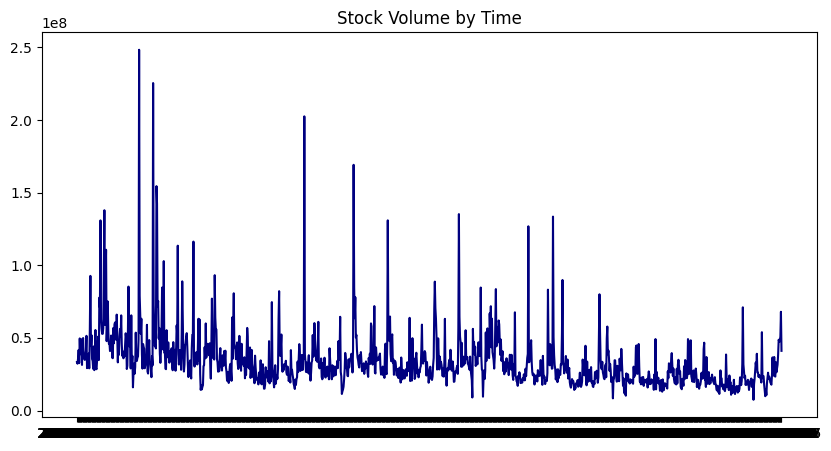

In [475]:
plt.figure(figsize=(10,5))
plt.plot(df_stock['date'],df_stock['volume'],label="Volume",color="navy")
plt.title("Stock Volume by Time")
plt.show()

In [476]:
# Drop non-numeric columns
num_cols = df_stock.select_dtypes(include=["int64","float64"])

## Check for correlation between features

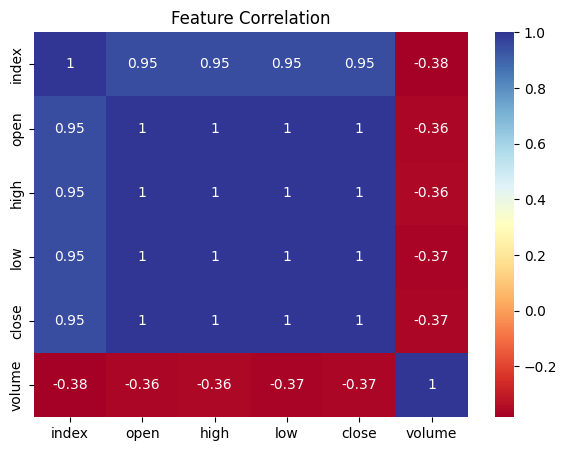

In [477]:
plt.figure(figsize=(7,5))
sns.heatmap(num_cols.corr(), annot=True, cmap="RdYlBu")
plt.title("Feature Correlation")
plt.show()

In [478]:
# Convert the Data into Date time then create a date filter
df_stock['date'] = pd.to_datetime(df_stock['date'])

In [479]:
prediction = df_stock.loc[
    (df_stock['date'] > datetime(2010,1,1)) &
    (df_stock['date'] < datetime(2025,1,1))
]

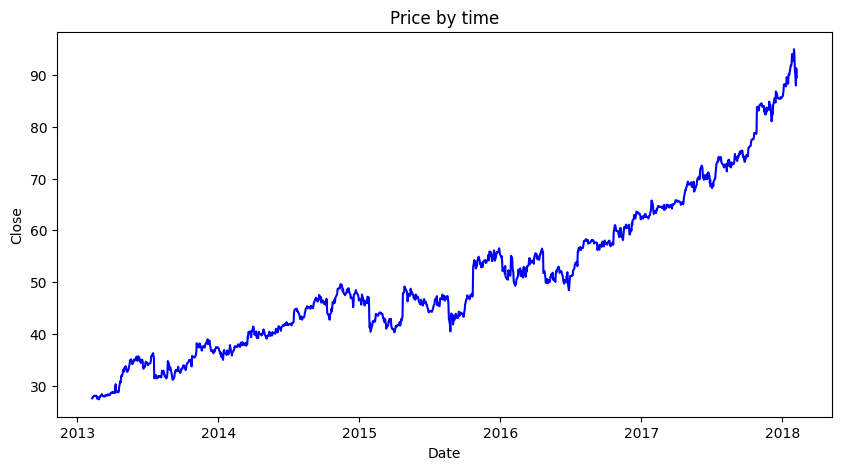

In [480]:
plt.figure(figsize=(10,5))
plt.plot(df_stock['date'], df_stock['close'],color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price by time")
plt.show()

In [481]:
PERC_DATA_FOR_TRAIN = 0.90

# Prepare for the LSTM Model (Sequential) to be trained on closing data
stock_close = df_stock.filter(["close"])
# convert to numpy array
dataset = stock_close.values 
# Consume 90% of the data for training
training_data_len = int(np.ceil(len(dataset) * PERC_DATA_FOR_TRAIN))

In [482]:
# Preprocessing Stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [483]:
#95% of all our data
training_data = scaled_data[:training_data_len] 

X_train, y_train = [], []

In [484]:
# Create a sliding window for our stock (90 days)
SLIDE_WIN = 90

for i in range(SLIDE_WIN, len(training_data)):
    X_train.append(training_data[i-SLIDE_WIN:i, 0])
    y_train.append(training_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [485]:
# Build the Model
model = keras.models.Sequential()
# Input Layer
model.add(keras.Input(shape=(X_train.shape[1], 1)))
# First Layer
model.add(keras.layers.LSTM(64, return_sequences=True))
# Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))
# 3rd Layer (Dense)
model.add(keras.layers.Dense(128, activation="relu"))
# 4th Layer (Dropout)
model.add(keras.layers.Dropout(0.5))
# Final Output Layer
model.add(keras.layers.Dense(1, activation="linear"))

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 90, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [486]:
model.compile(
    optimizer="adam",
    loss="mae",
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

In [487]:
# Define EarlyStopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_rmse',       # what to watch
    mode='min',               # We want to minimize RMSE
    patience=10,              # wait 10 epochs after no improvement
    restore_best_weights=True # roll back to best model
)

In [488]:
history = model.fit(
    X_train, y_train, 
    validation_split=0.2,
    epochs=200, batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.2852 - rmse: 0.3897 - val_loss: 0.3156 - val_rmse: 0.3566
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1386 - rmse: 0.1862 - val_loss: 0.3016 - val_rmse: 0.3403
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1207 - rmse: 0.1615 - val_loss: 0.3246 - val_rmse: 0.3581
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.1125 - rmse: 0.1515 - val_loss: 0.1292 - val_rmse: 0.1651
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1179 - rmse: 0.1581 - val_loss: 0.2707 - val_rmse: 0.3061
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1046 - rmse: 0.1407 - val_loss: 0.1960 - val_rmse: 0.2315
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1061 - rmse: 0.1432 - val_loss: 0.1586 - val_rmse: 0.1902
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0961 - rmse: 0.1284 - val_loss: 0.1936 - val_rmse: 0.2255
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1

In [489]:
hist = history.history

rmse_key = 'val_rmse' if 'val_rmse' in hist else 'val_root_mean_squared_error'

best_idx = int(np.argmin(hist[rmse_key]))   # epoch index (0-based)
best_epoch = best_idx + 1                   # human-friendly

best_snapshot = {k: hist[k][best_idx] for k in hist.keys()}

print(f"Best epoch: {best_epoch}")
print(f"Best {rmse_key}: {hist[rmse_key][best_idx]:.6f}")
for k, v in best_snapshot.items():
    print(f"{k}: {v:.6f}")

Best epoch: 36
Best val_rmse: 0.061767
loss: 0.078726
rmse: 0.106364
val_loss: 0.049299
val_rmse: 0.061767


In [490]:
# Prepare the test data
test_data = scaled_data[training_data_len - SLIDE_WIN:]
X_test, y_test = [], dataset[training_data_len:]


In [491]:
for i in range(SLIDE_WIN, len(test_data)):
    X_test.append(test_data[i-SLIDE_WIN:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))

In [492]:
# Make a Prediction
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


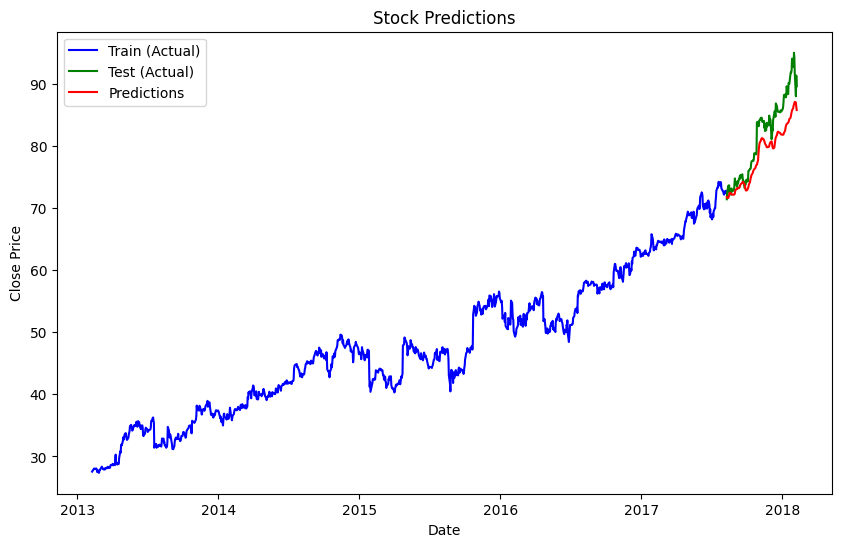

In [493]:
# Plotting data
train = df_stock[:training_data_len]
test =  df_stock[training_data_len:]

test = test.copy()

test['Predictions'] = y_pred

plt.figure(figsize=(10,6))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='green')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()